In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from badlands import meshtools 
from badlands import TreMesh
from badlands import HeightMesh
from badlands import SurfaceProcessMesh

import numpy as np

In [21]:

# Build a higher resolution mesh which we can use to test the erosion toolkit

x1, y1, bmask, inverse_bmask = meshtools.elliptical_mesh(-5.0, 5.0, -5.0,  5.0, 0.05, 0.05, 10000, 75 )
x5,y5 = meshtools.lloyd_mesh_improvment(x1,y1, bmask, 5)
z5 = np.exp(-0.025*(x5**2 + y5**2)**2) + 0.0001 * np.random.rand(len(x5))
z5 -= z5[inverse_bmask].mean()     # Boundary is at zero which we define as the base level

r5 = z5**2 # Rainfall pattern

uplift = z5

mesh5 = SurfaceProcessMesh(x5, y5, z5, r5, None, uplift, bmask, verbose=True)


Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
 - Calculating Delaunay Triangulation  0.047782 s
 - Triangulation Neighbour Lists  0.344484 s
 - Triangulation Local Areas and Weights  0.253148 s
 - Triangulation Vector Operators  0.267879 s
 - Local Smoothing Operator  0.046126 s
 - Sorted all nodes by height (high to low)  0.020734 s
 - Built downhill matrices  0.027578 s
 - Built cumulative area 0.005869 s
 - Found low points 0.003645 s
 - Found outflow points 0.002765 s


In [69]:
## Compute a downstream gradient matrix ... don't need it !!! 

# 1st of all ... does it work ?

from scipy import sparse as sparse

dist = np.sqrt((mesh5.x - mesh5.downhillMat.T.dot(mesh5.x))**2 + 
               (mesh5.y - mesh5.downhillMat.T.dot(mesh5.y))**2 )

gradient = (mesh5.height - mesh5.downhillMat.T.dot(mesh5.height)) / dist
np.clip(gradient, 0.0, gradient.max(), gradient)

distMat = sparse.spdiags(1.0/dist, 0, mesh5.tri.npoints, mesh5.tri.npoints, format='csr')
gradMat = sparse.identity(mesh5.tri.npoints, format='csr') - mesh5.downhillMat.T
gradMat = distMat.dot(gradMat)

In [79]:
cumArea = mesh5.cumulative_flow(mesh5.area)
cumAreaMat = sparse.spdiags(cumArea, 0, mesh5.tri.npoints, mesh5.tri.npoints, format='csr')
spMat = cumAreaMat.dot(gradMat)

stm_power1 = mesh5.upstream_area * mesh5.slope
stm_power2 = spMat.dot(mesh5.height)

In [87]:
## Matrix problem 

## Assume kappa = constant for the moment 

kappa = 0.001
diff_matrix = kappa * mesh5.gradM2
hdot = diff_matrix.dot(mesh5.height)
hdot2 = -spMat.dot(mesh5.height)

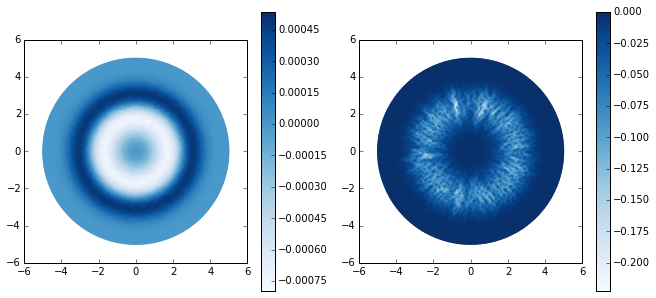

In [88]:
fig, (plot1,plot2) = plt.subplots(1,2)

fig.set_size_inches(11,5)

plot1.set_aspect("equal")
plot2.set_aspect("equal")

sm1 = mesh5.add_node_data_to_plot(plot1, hdot, cmap=cm.Blues,  shading="gouraud")
fig.colorbar(sm1, ax=plot1)

sm2 = mesh5.add_node_data_to_plot(plot2, hdot2, cmap=cm.Blues,  shading="gouraud")
fig.colorbar(sm2, ax=plot2)

fig.savefig("gradients.png",dpi=600)



In [59]:
%%sh

open gradients.png